# Projeto - NLP

## Os Dados

Dataset obtido do Twitter com 100K postagens entre os dias 01/08/2018 e 20/10/2018. Cada postagem é classificada como **positiva**, **negativa** ou **neutra**.  

Dois arquivos serão disponilizados para o desenvolvimento dos modelos, um para treino/validação e outro para submissão. Os arquivos se encontram na pasta */Dados/train* e */Dados/subm*, respectivamente.

Descrição das colunas:

- **id**: ID único para o tweet  
- **tweet_text**: Texto da publicação no Twitter  
- **tweet_date**: Data da publicação no Twitter  
- **sentiment**: 0, se negativo; 1, se positivo; 2, se neutro  
- **query_used**: Filtro utilizado para buscar a publicação

Criar um modelo para detectar o sentimento de uma publicação do Twitter a classificando em uma das três categorias: **positiva**, **negativa** ou **neutra**. O texto da publicação está disponível na coluna "tweet_text".

|id|sentiment_predict
|-|-|
|12123232|0
|323212|1
|342235|2

# Desenvolvimento do projeto

In [1]:
# Bibliotecas
import string
from unidecode import unidecode

import numpy as np
import pandas as pd 

# Visualização
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import missingno as msno

# Seleção de modelo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modelos
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier

# Extração de features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Pré processamento
from gensim.utils import simple_preprocess
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Natural Language Tool Kit
import nltk
nltk.download('rslp')
from nltk.stem import RSLPStemmer


[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [2]:
# Funções 

# ------------------------------ Da aula ------------------------------
def plot_wordcloud(texts):
    plt.figure(figsize=(15.5, 13))
    text = ' '.join(texts.tolist())
    WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
    words = WC.generate(text)
    plt.imshow(words)
    plt.show()


def tokenize(text):
    text = text.lower()
    return simple_preprocess(text, min_len=1)


def to_word_vector(words, w2v):  #Adaptado por causa de atualização da biblioteca e por causa de frases vazias
    vectors = []
    for word in words:
        vectors.append([w2v.wv[word] if word in w2v.wv.key_to_index else np.zeros(w2v.vector_size)])
    if len(vectors) > 0: 
        return np.mean(vectors, axis=0)
    else:
        return [np.zeros(w2v.vector_size).tolist()] # Se a tokenização de um tweet for vazio

    
def embeddings(x, w2v):
    x = x.copy()   
    x = x.apply(tokenize)
    x = np.vstack([to_word_vector(sentences, w2v) for sentences in x])
    return x


# ------------------------------ Criadas ------------------------------ 
# Métricas
def metricas(y_treino, y_treino_pred, y_valid, y_valid_pred, tipo):
    acc_train = accuracy_score(y_treino, y_treino_pred)
    prec_train = precision_score(y_treino, y_treino_pred, average='weighted')
    rec_train = recall_score(y_treino, y_treino_pred, average='weighted')

    acc_valid = accuracy_score(y_valid, y_valid_pred)
    prec_valid = precision_score(y_valid, y_valid_pred, average='weighted')
    rec_valid = recall_score(y_valid, y_valid_pred, average='weighted')

    print(f'Treino:\nAcc: {acc_train:.3f}, Precision: {prec_train:.3f}, Recall: {rec_train:.3f}')
    print(f'{tipo}:\nAcc: {acc_valid:.3f}, Precision: {prec_valid:.3f}, Recall: {rec_valid:.3f}')

    
# Remove pontuação, caracteres especiais, faz STEM e remove acentuação
st = RSLPStemmer()
def transforma_frase(frase):
    frase = frase.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) #remove pontuação e caracteres especiais
    palavras = frase.split()
    palavras = [st.stem(x) for x in palavras] #STEM
    frase_transformada = ' '.join(palavras)
    return unidecode(frase_transformada) #remove acentuação

# Encontra palavras estranhas segundo o critério de frequência no dataset
# Cuidado, essa função utiliza CountVectorizer
def palavras_estranhas(dados,texto, freq_max, max_iter):    
    #dados: dataframe com os dados
    #texto: nome da feature do dataframe onde está o texto
    #freq_max: frequencia máxima que a palavra pode ter dentro de todo o dataset para que seja considerada palavra estranha
    #max_iter: número máximo de iterações do CountVectorizer para encontrar as palavras
    #No código palavras ruins são sinônimos de palavras estranhas (palavras_estranhas é a função, palavras_ruins é a lista gerada)
    
    saida = []
    palavras_ruins = ['a']  #inicializar a lista com tamanho maior que 0
    conta_iter = 0
    
    if max_iter == -1: # Como se fosse infinito, max_iter fica em 1000 iterações
        max_iter = 1000
    
    # Laço que para quando atinge o max_iter ou não são encontradas novas palavras ruins
    while len(palavras_ruins) > 0 and conta_iter < max_iter:
        palavras_ruins = []
        
        # O CountVectorizer conta as palavras com stop_words que vão aumentando em cada iteração do while
        # A stop_words=saida são o acumulo de palavras_ruins de cada iteração do laço
        vectorizer = CountVectorizer(max_features=25000, strip_accents='unicode', stop_words=saida)
        vectorizer.fit(dados[texto])

        dados_transformados = vectorizer.transform(dados[texto]).toarray()    
        dados_transformados_transp = dados_transformados.T #transposto fica mais facil de fazer a contagem de palavras
        del dados_transformados 
    
        for id_palavra in range(len(dados_transformados_transp)):
            contagem = dados_transformados_transp[id_palavra].sum() #soma a contagem da palavra de cada tweet
            if contagem <= freq_max: #se a contagem for menor ou igual que a freq_max, adiciona a palavra em palavras_ruins
                palavras_ruins.append(list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(id_palavra)])
        
        del dados_transformados_transp
        saida = saida + palavras_ruins #acumula as palavras ruins
        print('Quantidade de palavras ruins:',len(saida))
        conta_iter += 1

    return saida


# Classifica as palavras em significantes e insignificantes (Ideia explicada melhor em Bag of Words)
# Cuidado, essa função utiliza CountVectorizer
def classifica_palavras(dados, texto, saida, freq_rel_corte, max_feat, palavras_excluidas):
    #dados: dataframe com os dados
    #texto: nome da feature do dataframe onde está o texto
    #saida: nome da feature do dataframe que é a saída
    #freq_rel_corte: frequência relativa de corte que define se a palavra é significante ou insignificante
                   # se a palavra tiver frequência relativa maior que frequência relativa de corte em pelo menos uma das 
                   # classes de saída, a palavra é considerada significante
    
    classes = dados[saida].unique()  #separa as classes de saída
    classes.sort()
    quant_classes = len(classes)
    
    dados_por_classe = []
    lista_freq_palav = []
    palavras_unicas = []
    
    for classe in classes:
        dados_por_classe.append(dados[dados[saida] == classe]) #separa dataframes por classe de saída
        print('Classe', classe)
        
        # Nessa parte a ideia é parecida com a da função palavras_estranhas, a diferença é que aqui cria-se um dicionario
        # com todas as palavras e a contagem de vezes que apareceu na classe
        vectorizer = CountVectorizer(max_features=max_feat, strip_accents='unicode', stop_words=palavras_excluidas)
        vectorizer.fit(dados_por_classe[classe][texto])
        
        dados_transformados = vectorizer.transform(dados_por_classe[classe][texto]).toarray()    
        dados_transformados_transp = dados_transformados.T
        del dados_transformados
        
        freq_palav = {}
        
        for id_palavra in range(len(dados_transformados_transp)):
            contagem = dados_transformados_transp[id_palavra].sum()
            freq_palav[list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(id_palavra)]] = contagem/np.shape(dados_transformados_transp)[1]
        
        del dados_transformados_transp
        lista_freq_palav.append(freq_palav) #lista com os dicionarios de cada classe
    
    # Preparação para inicializar o dicionario com as frequencias das classes
    freq_prim_classe = np.array(list(lista_freq_palav[0].values()))
    zeros = np.zeros((len(np.vstack(freq_prim_classe)), len(classes)-1))
    vetor_prim_classe = np.block([[np.vstack(freq_prim_classe), zeros]])

    # Dicionario com as palavras e frequencias da primeira classe
    frequencia_palavras = dict(zip(lista_freq_palav[0].keys(), vetor_prim_classe))

    # Adição das palavras e frequencias das outras classes
    for i in range(1,quant_classes):
        for palavra in lista_freq_palav[i]:
            if palavra in frequencia_palavras:
                frequencia_palavras[palavra][i] = lista_freq_palav[i][palavra]
            else:
                frequencia_palavras[palavra] = np.zeros(quant_classes)
                frequencia_palavras[palavra][i] = lista_freq_palav[i][palavra]
    
    
    # Classificação se a palavra é significante ou insignificante
    palavras_insignificantes = []
    palavras_significantes = []

    for palavra in frequencia_palavras.keys():
        media = frequencia_palavras[palavra].mean() # frequência relativa média de uma palavra entre as classes
        distancia_freq_media = abs(frequencia_palavras[palavra]-media) # distância entre a frequência rel da palavra em cada classe e a frequência relativa média
        
        palavra_significante = False
        for i in range(quant_classes):
            if distancia_freq_media[i] > freq_rel_corte:
                palavra_significante = True
                break
                
        if palavra_significante:
            palavras_significantes.append(palavra)
        else:
            palavras_insignificantes.append(palavra)

    return palavras_significantes, palavras_insignificantes


In [3]:
#Carregar dataset
df_modelagem = pd.read_csv('Dados/train/Train3classes.csv')
df_subm = pd.read_csv('Dados/subm/Subm3classes.csv')
df_modelagem.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:)


# 1 Divisão dos dados

A divisão dos dados entre experimento e teste pode ser feita de forma aleatória ou de forma temporal. No caso temporal, a base experimento fica com os dados mais antigos e a base teste com os dados mais novos. Dessa forma é possível simular que o modelo foi primeiramente produzido com dados "antigos" e testado em dados "novos".  

A seguir será feita a análise para entender qual a melhor forma de dividir os dados.

In [4]:
percentual_teste = 0.2
percentual_treino = 1-percentual_teste

In [5]:
df_modelagem['tweet_date'] = pd.to_datetime(df_modelagem['tweet_date'])  #muda para o tipo datetime
df_modelagem['ano_mes_dia'] = df_modelagem['tweet_date'].dt.strftime('%Y/%m/%d') #cria uma coluna com os dias

df_modelagem.sort_values(by='tweet_date', inplace=True) #ordena tweets pela data crescente
df_modelagem.reset_index(drop=True, inplace=True)
df_modelagem.head()

,id,tweet_text,tweet_date,sentiment,query_used,ano_mes_dia
0,1027373651585249280,Anavitória industrializa pop folk em álbum pau...,2018-08-09 01:59:00+00:00,2,g1,2018/08/09
1,1030466921702076416,"Está no ar o CandidatoWEB, seu novo portal de ...",2018-08-17 14:50:33+00:00,2,#trabalho,2018/08/17
2,1030467484766359552,Confira esta vaga na Groupe L’OCCITANE: Gerent...,2018-08-17 14:52:48+00:00,2,#oportunidade,2018/08/17
3,1030468147353210881,Confira esta vaga na Grupo SABEMI: Assistente ...,2018-08-17 14:55:26+00:00,2,#oportunidade,2018/08/17
4,1030468564715794432,Confira esta vaga na Senac-RS: Editor De Video...,2018-08-17 14:57:05+00:00,2,#oportunidade,2018/08/17


<AxesSubplot:xlabel='ano_mes_dia'>

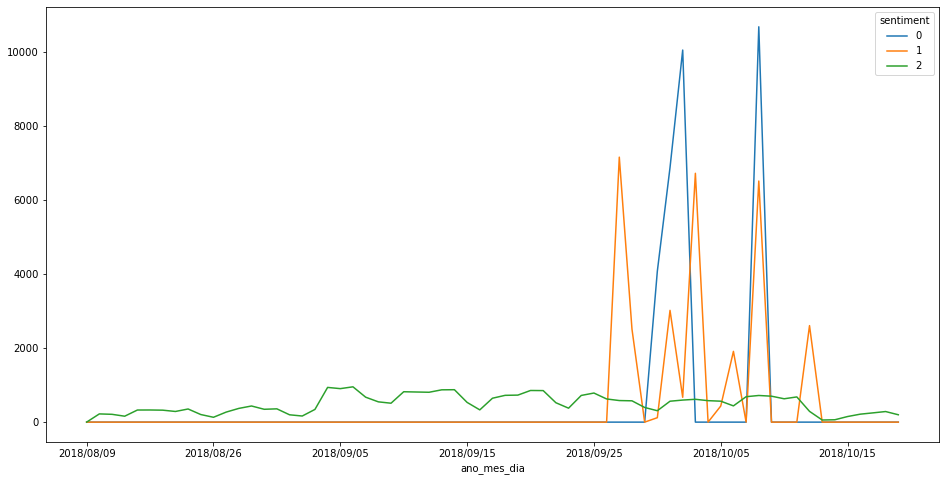

In [6]:
#conta os tweets agrupados por dia e sentimento
df_tweets_por_dia = df_modelagem.groupby(['ano_mes_dia', 'sentiment'])['id'].count().reset_index()

#reorganiza a tabela
df_tweets_por_dia = pd.pivot_table(df_tweets_por_dia, values='id', index='ano_mes_dia', columns='sentiment').fillna(0)
df_tweets_por_dia.plot(figsize=(16, 8))

<AxesSubplot:xlabel='ano_mes_dia'>

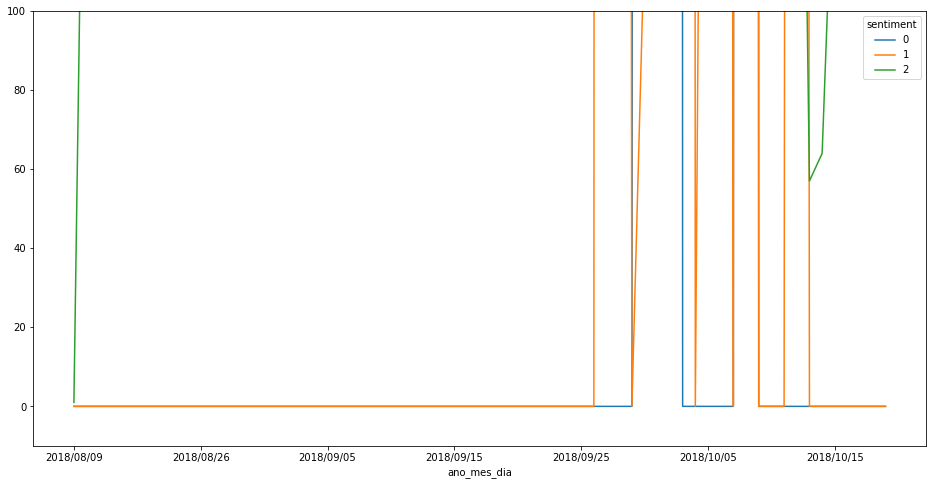

In [7]:
#Limitar a visualização do eixo Y (mais próximo de 0) para ver se existem tweets com sentimento 
#positivo e/ou negativo nos meses de agosto e setembro
df_tweets_por_dia.plot(figsize=(16, 8), ylim=(-10,100))

Os gráficos acima mostram que durante a maior parte do tempo, só se tem tweets com sentimento neutro. E que os tweets com sentimento positivo e negativo acontecem em um curto espaço de tempo (entre final de setembro e meio de outubro).

O próximo gráfico mostra a quantidade total de tweets por dia junto com a linha vermelha que divide os dados de treino e teste baseado no percentual_treino definido no início.

In [8]:
df_total_tweets_por_dia = df_tweets_por_dia.sum(axis=1).reset_index() #soma os tweets por dia
df_total_tweets_por_dia.rename(columns={0: "Total"}, inplace=True)

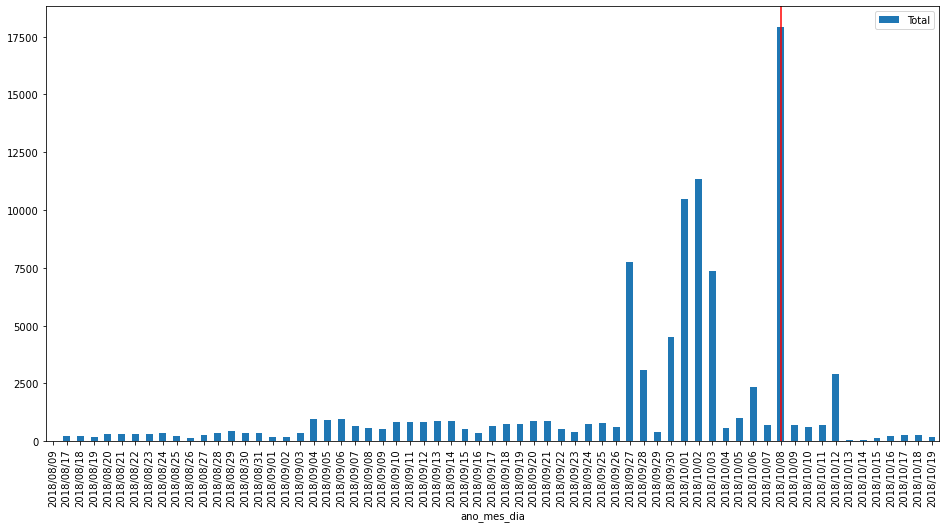

In [9]:
distribuicao = df_total_tweets_por_dia.plot(figsize=(16, 8), kind='bar', x='ano_mes_dia') #plota a distribuição de tweets

# Código utilizado para plotar a linha vermelha que divide os dados em treino e teste
# Pega o xtick do dia na qual acontece a divisão dos dados
dia_divisao = df_modelagem['tweet_date'].quantile(percentual_treino).strftime('%Y/%m/%d')

# Encontra a posição do xtick baseado no dia_divisao
for label in distribuicao.get_xticklabels():
    if label.get_text() == dia_divisao:
        posicao_x = label.get_position()[0]
        
plt.axvline(x=posicao_x, color='#FF0000');        

In [10]:
#Contagem de tweets da base experimento
mais_novos_80 = df_modelagem[df_modelagem['tweet_date'] < df_modelagem['tweet_date'].quantile(percentual_treino)]
print('Total de tweets:', len(mais_novos_80))
mais_novos_80.groupby(by=['sentiment'])['id'].count()

Total de tweets: 76000


sentiment
0    23318
1    25135
2    27547
Name: id, dtype: int64

In [11]:
#Contagem de tweets da base teste
mais_velhos_20 = df_modelagem[df_modelagem['tweet_date'] >= df_modelagem['tweet_date'].quantile(percentual_treino)]
print('Total de tweets:', len(mais_velhos_20))
mais_velhos_20.groupby(by=['sentiment'])['id'].count()

Total de tweets: 19000


sentiment
0    8378
1    6543
2    4079
Name: id, dtype: int64

Com a base de teste em 20%, fazer a divisão em experimento e teste da forma temporal parece meio arriscado. O teste ficará com bastantes dados com sentimentos positivo e negativo e poucos dados neutros, enquanto a base de experimento possui a maioria dos registros com sentimento neutro.

**Então a divisão em experimento e teste será de forma aleatória**

In [12]:
# Divide o dataframe em experimento e teste, o df_experimento será dividido em treino e validação posteriormente
df_experimento, df_teste = train_test_split(df_modelagem, test_size=percentual_teste, random_state=12)

print(df_experimento.shape)
print(df_teste.shape)

(76000, 6)
(19000, 6)


In [13]:
df_experimento.groupby(by=['sentiment'])['id'].count()

sentiment
0    25448
1    25314
2    25238
Name: id, dtype: int64

In [14]:
df_teste.groupby(by=['sentiment'])['id'].count()

sentiment
0    6248
1    6364
2    6388
Name: id, dtype: int64

**A divisão aleatória deixa a distribuição homogênea**

# 2 Tratamento dos dados

## 2.1 Dados faltantes

<AxesSubplot:>

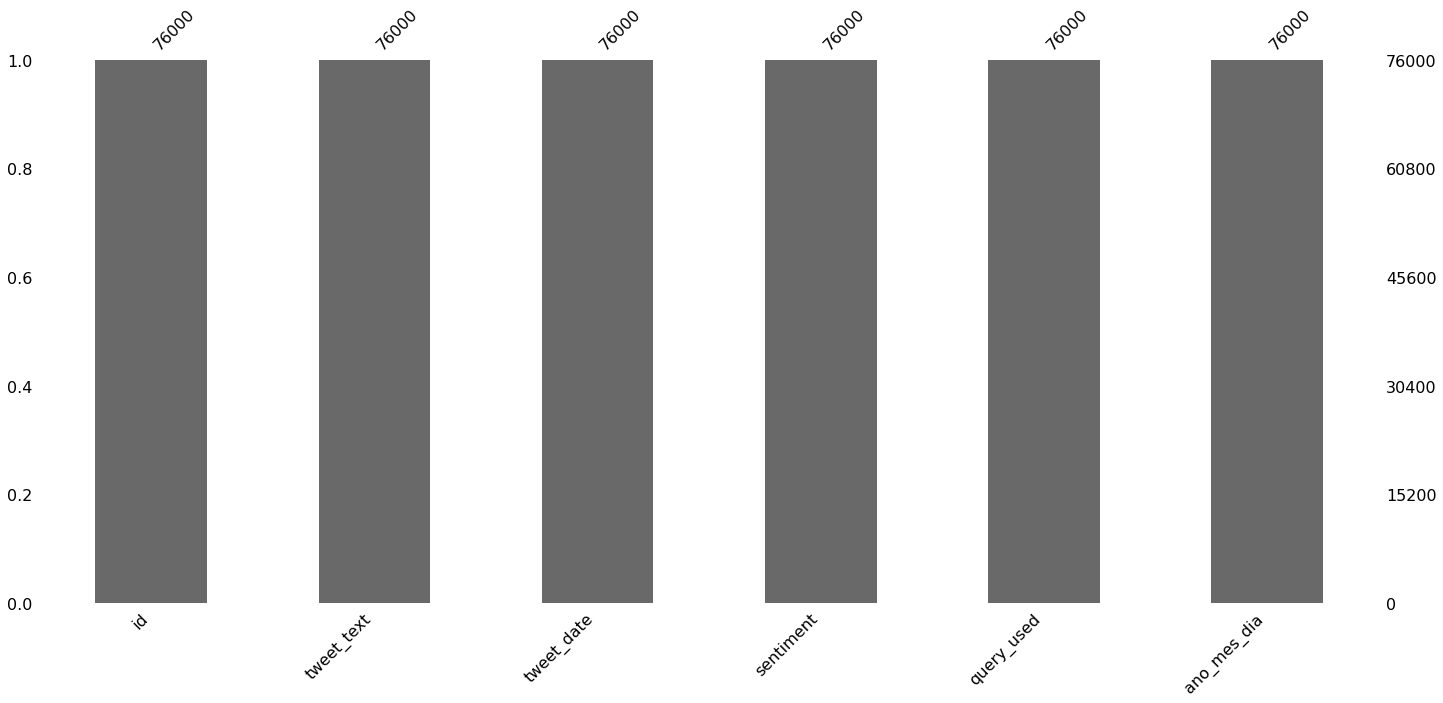

In [15]:
#Visualização de dados faltantes
msno.bar(df_experimento)

Sem dados faltantes

## 2.2 Dados duplicados

In [16]:
df_experimento.duplicated(subset=['id']).value_counts()

False    75993
True         7
dtype: int64

Remoção de duplicados

In [17]:
df_experimento.drop_duplicates(subset=['id'], inplace=True)
df_experimento.duplicated(subset=['id']).value_counts()

False    75993
dtype: int64

## 2.3 Formatar tweets

Como os algoritmos estudados utilizam apenas palavras para prever resultados (sem pontuação ou coisas do gênero), acredito que essa formatação básica pode ser aplicada a qualquer texto sem análise prévia:

- remove pontuação e caracteres especiais;
- faz STEM;
- remove acentuação

In [18]:
# Fazer direto na base experimento para economizar código
df_experimento['tweet_text'] = df_experimento['tweet_text'].apply(lambda x: transforma_frase(x))

# 3 Análise Exploratória

## 3.1 Palavras mais comuns

Sentimento 0


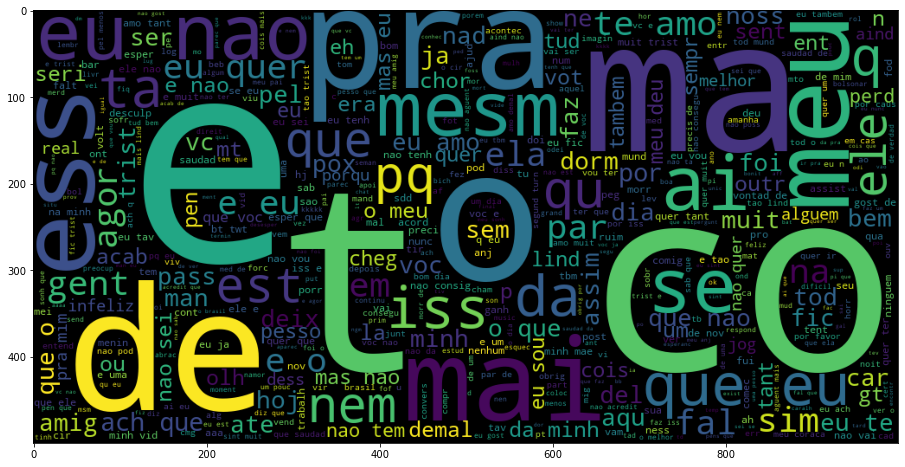

Sentimento 1


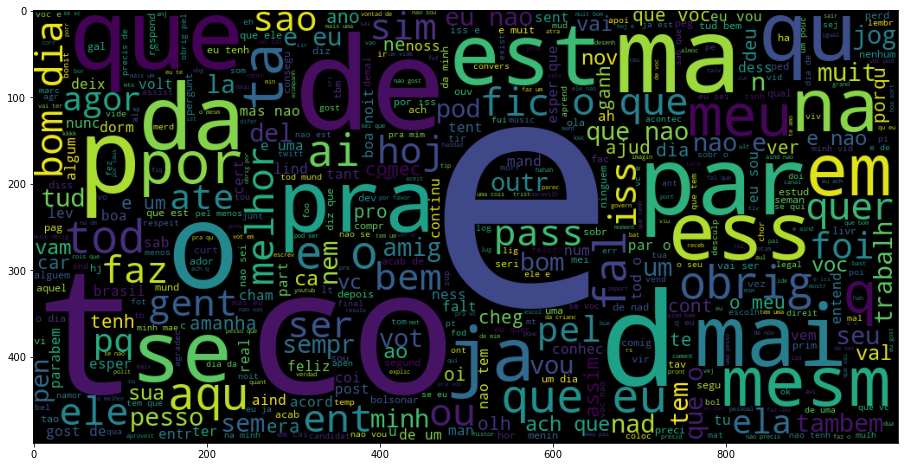

Sentimento 2


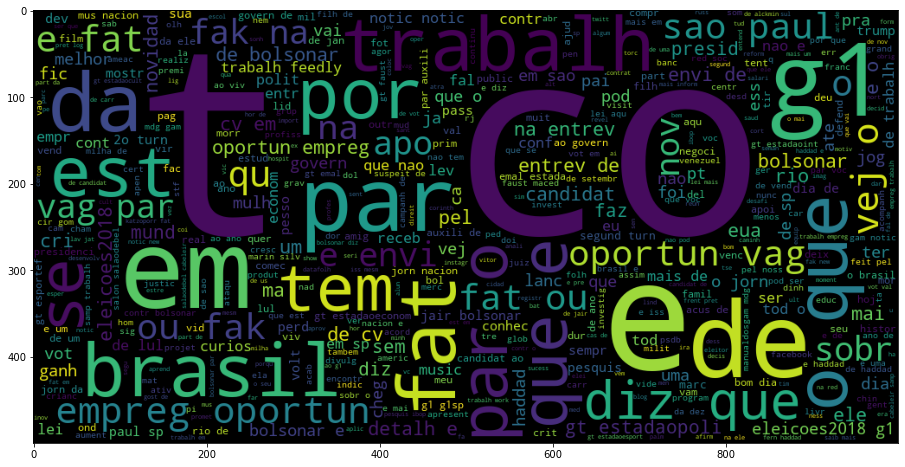

In [19]:
sentimentos = df_experimento['sentiment'].unique()
sentimentos.sort()
lista_df_por_sentimento = []
for i in sentimentos:
    lista_df_por_sentimento.append(df_experimento[df_experimento['sentiment'] == i])
    print('Sentimento', i)
    plot_wordcloud(lista_df_por_sentimento[i]['tweet_text'])

- A maioria das palavras para os 3 sentimentos são palavras pequenas como "de", "da", "por", "que", "e", "o", "pra"
- Aparentemente não precisa remover sintaxe de alguma linguaguem com a biblioteca BeautifulSoap

O WordCloud evidencia apenas as palavras mais comuns, porém é importante analisar também as palavras menos comuns.  
Acredito que palavras que aparecem 1 única vez em 76000 tweets não tem signifcado algum. Como a comunicação acontece pela combinação de palavras que formam o contexto desejado. Se a palavra é utilizada uma única vez em 76000 tweets, acredito que essa palavra não tenha significado em contexto nenhum pois ela não é utilizada por outras pessoas.

Então criei uma função para capturar as palavras com baixa frequência. A função utiliza o CountVectorizer para contar as palavras e retorna apenas as palavras que tiverem frequência menor ou igual a frequência máxima.

A frequência máxima é o máximo de vezes que uma palavra pode se repetir no dataset para que ela ainda seja considerada uma palavra estranha. Ou seja, se a palavra se repetir mais que a frequência máxima, ela não é considerada palavra estranha.

Para essa análise, foi usado 1 como frequência máxima (palavras que acontecem uma vez são estranhas, as outras não).

## 3.2 Palavras menos comuns

In [20]:
#Precisa de aproximadamente 14Gb de memória ram livre (Windows 11)
palavras_ruins = palavras_estranhas(df_experimento,'tweet_text', 1, 1)

Quantidade de palavras ruins: 4545


In [21]:
print('Quantidade de palavras estranhas',len(palavras_ruins))
palavras_ruins[:15]

Quantidade de palavras estranhas 4545


['marinamo',
 'marinaortegan',
 'marinaperson1',
 'marinarehd',
 'marinarios07',
 'marinaross',
 'marinaruybarb',
 'marinas',
 'marinasilva18',
 'marinasilvanavej',
 'marinaskf',
 'marinatwr',
 'marinazord',
 'marindagu',
 'maringateytey']

In [22]:
palavras_ruins[-15:-1]

['q2idttzubc',
 'q2iwrzqf0w',
 'q2k0hmk2sd',
 'q2l7yj6fsw',
 'q2lpi67py2',
 'q2maaz8cjk',
 'q2mzdrmzw',
 'q2pec3srlk',
 'q2przjywqj',
 'q2q86zqtfx',
 'q2s8caotw',
 'q2safkru1n',
 'q2skfywovu',
 'q2zhj1sat']

Como suspeitado, essas palavras são lixo, sem qualquer significado. Provavelmente elas aumentam o overfitting entre treino e validação. Se estão contidas na base de treino, o modelo "aprenderá" com palavras que serão preditas apenas na própria base de treino.  
Essas palavras provavelmente deverão ser excluídas.

# 4 Modelagem

In [23]:
df_treino, df_valid = train_test_split(df_experimento, test_size=0.3, random_state=12)
df_treino.reset_index(drop=True, inplace=True)

print(df_treino.shape)
print(df_valid.shape)

(53195, 6)
(22798, 6)


## 4.1 Bag of Words

- Não leva em consideração a sequência das palavras.  
- Conta a quantidade de vezes que cada palavra aparece em um texto. 
- Conta apenas as palavras que estão contidas no vocabulário treinado.

**A escolha do algoritmo de aprendizado Naive Bayes se deu por causa da velocidade e bom desempenho apresentados em aula**

### 4.1.1 Bag of Words sem remoção de palavras estranhas

In [24]:
vectorizer = CountVectorizer(max_features=15000, strip_accents='unicode')

# Escolha do Naive Bayes por ter sido apresentado na aula, rápido e com bom desempenho.
# Não pesquisei sobre os parâmetros, então tudo no padrão.
modelo = MultinomialNB()

#Treino
vectorizer.fit(df_treino['tweet_text']) 
treino_transformado = vectorizer.transform(df_treino['tweet_text']).toarray() #vetorização da base de treino
modelo.fit(treino_transformado, df_treino['sentiment']) #treino
y_treino_pred = modelo.predict(treino_transformado) #predição

#Validação
valid_transformado = vectorizer.transform(df_valid['tweet_text']).toarray() #vetorização da base de validação
y_valid_pred = modelo.predict(valid_transformado)

metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.820, Precision: 0.819, Recall: 0.820
Validação:
Acc: 0.781, Precision: 0.779, Recall: 0.781


4% de diferença entre o treino e validação (overfitting). Realmente, as palavras estranhas devem estar causando esse overfitting.

In [25]:
# Liberar memória ram
del treino_transformado
del valid_transformado
del vectorizer

### 4.1.2 Bag of Words com remoção de palavras estranhas

A lista de palavras ruins encontradas na análise exploratória não corresponde à lista completa por 2 motivos:
- 1) O CountVectorizer foi executado uma só vez, isso quer dizer que aquela lista possui apenas as palavras ruins dentre as 25000 palavras separadas pelo CountVectorizer;
- 2) Foi usado o dataframe df_experimento, o correto aqui é usar o df_treino.

Então aqui será encontrada a lista completa de palavras que aparecem uma única vez na base de treino. A função vai aumentando a quantidade de stop_words em cada iteração, até que não haja mais palavras que só ocorrem uma vez.

In [26]:
# Demora um pouco: 8 iterações de CountVectorizer com max_features = 25000 (necessário pelo menos 11Gb de memória ram livre)
palavras_ruins = palavras_estranhas(df_treino,'tweet_text', 1, -1)

Quantidade de palavras ruins: 8946
Quantidade de palavras ruins: 17892
Quantidade de palavras ruins: 26838
Quantidade de palavras ruins: 35784
Quantidade de palavras ruins: 44730
Quantidade de palavras ruins: 53676
Quantidade de palavras ruins: 59456
Quantidade de palavras ruins: 59456


In [27]:
vectorizer = CountVectorizer(max_features=15000, strip_accents='unicode', stop_words=palavras_ruins)
modelo = MultinomialNB() 

#Treino
vectorizer.fit(df_treino['tweet_text']) 
treino_transformado = vectorizer.transform(df_treino['tweet_text']).toarray() #vetorização da base de treino
modelo.fit(treino_transformado, df_treino['sentiment']) #treino
y_treino_pred = modelo.predict(treino_transformado) #predição

#Validação
valid_transformado = vectorizer.transform(df_valid['tweet_text']).toarray() #vetorização da base de validação
y_valid_pred = modelo.predict(valid_transformado)

metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.821, Precision: 0.819, Recall: 0.821
Validação:
Acc: 0.780, Precision: 0.778, Recall: 0.780


Diferentemente do esperado, não houve melhoria no overfitting. Talvez isso seja pelo fato de que como cada palavra acontece uma única vez, o aloritmo de aprendizado não dê tanta importancia para elas.
Mesmo que não tenha melhoria no overfitting, manterei a lista palavras_ruins como stop_words nos próximos passos pois não faz sentido usá-las como features.

A segunda ideia é apresentada no tópico a seguir.

In [28]:
# Liberar memória ram
del treino_transformado
del valid_transformado
del vectorizer

### 4.1.3 Ideia de remoção de palavras insignificantes

A ideia é remover palavras que não tem significado perante as classes de saída. A classificação se a palavra é significante ou insignificante será por algo parecido com a frequência relativa de cada palavra em cada uma das classes de saída.  

Seria frequência relativa se $\frac{quantPalavra}{quantTotaldePalavras}$, porém a conta feita para entender a proporção de palavras é de acordo com a quantidade de tweets:  $\frac{quantPalavra}{quantTweets}$. Nessa conta, se uma palavra é repetida muitas vezes no mesmo tweet e na maioria dos tweets, o valor pode ficar maior que 1, mas isso não é problema para essa classficação.

Ao calcular a "frequência relativa" das palavras separadas por classe de saída, é possível compara-las para entender se alguma acontece com maior frequência relativa em pelo menos uma das classes.

Exemplo: se a palavra "bom" aparece 500 vezes nos 1000 tweets de sentimento positivo, 80 vezes nos 800 tweets de sentimento negativo e 300 vezes nos 1000 tweets de sentimento neutro, as frequências relativas da palavra "bom" serão 50%, 10% e 30%.

No exemplo percebe-se facilmente que a palavra bom é significante pois ela acontece com frequência relativa muito maior para tweets com sentimento positivo.

Classificação da palavra: faz-se a média das frequências e calcula a distância entre a média e a frequência relativa de cada sentimento. Com as distâncias compara-se com uma frequência relativa de corte. Se pelo menos uma distância for maior que a frequência de corte a palavra é considerada significante, isso quer dizer a palavra ocorre com frequência relevantemente maior em pelo menos uma classe.

No exemplo, a média é 30%.  As distâncias em relação à media são 20%, 20% e 0%. Se a frequência de corte for maior que 20% a palavra "bom" é considerada insignificante. Se a frequência de corte for menor que 20% a palavra é significante.

**As palavras insignificantes são utilizadas no parâmetro stop_words do objeto CountVectorizer para criar a Bag of Words menor**


In [29]:
frequencia_corte = 0.0007

Testei a frequencia_corte com 1%, porem ficaram pouco mais de 130 palavras significantes, depois 0,1% e por fim cheguei em 0,07%

A ideia aqui é repetir a função classifica_palavras() sempre adicionando as palavras insignificantes na nova iteração até que a quantidade de palavras insignificantes seja zero.

In [30]:
# a recebe as palavras significantes entre as 25000 e b as insignificantes
a, b = classifica_palavras(df_treino, 'tweet_text', 'sentiment', frequencia_corte, 25000, palavras_ruins)

print('Quantidade de palavras significantes:', len(a))
print('Quantidade de palavras insignificantes:', len(b))

Classe 0
Classe 1
Classe 2
Quantidade de palavras significantes: 1745
Quantidade de palavras insignificantes: 14309


In [31]:
palavras_insignificantes = palavras_ruins + b

In [32]:
a, b = classifica_palavras(df_treino, 'tweet_text', 'sentiment', frequencia_corte, 25000, palavras_insignificantes)

print('Quantidade de palavras significantes:', len(a))
print('Quantidade de palavras insignificantes:', len(b))

Classe 0
Classe 1
Classe 2
Quantidade de palavras significantes: 1745
Quantidade de palavras insignificantes: 0


In [33]:
vectorizer = CountVectorizer(max_features=15000, strip_accents='unicode', stop_words=palavras_insignificantes)
modelo = MultinomialNB() 

#Treino
vectorizer.fit(df_treino['tweet_text']) 
treino_transformado = vectorizer.transform(df_treino['tweet_text']).toarray() #vetorização da base de treino
modelo.fit(treino_transformado, df_treino['sentiment']) #treino
y_treino_pred = modelo.predict(treino_transformado) #predição

#Validação
valid_transformado = vectorizer.transform(df_valid['tweet_text']).toarray() #vetorização da base de validação
y_valid_pred = modelo.predict(valid_transformado)

metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.779, Precision: 0.775, Recall: 0.779
Validação:
Acc: 0.771, Precision: 0.768, Recall: 0.771


A remoção de palavras insignificantes, além de diminuir a quantidade de features (deixa o modelo mais rápido para previsões), diminuiu o overfitting. 

Eu não esperva que fosse diminuir o overfitting. Então acredito que isso tenha ocorrido porque se essas palavras não tem significado perante a classe de saída (sentimento), mante-las no modelo ajuda no desempenho apenas da base de treino.

Porém o vacabulário pequeno como esse dá a sensação de que o resultado dessa validação foi sorte.

In [34]:
# Cross Validation para validar os resultados
cv_results = cross_validate(modelo, treino_transformado, df_treino['sentiment'], cv=10, return_train_score=True)
acuracia = pd.DataFrame({'Treino':cv_results['train_score'],'Validação':cv_results['test_score']})
print('Acurácia\n')
print(acuracia.mean())

Acurácia

Treino       0.779511
Validação    0.770373
dtype: float64


Valores de treino em 78%  e validação em 77%

## 4.2 TF-IDF
- É um Bag of Words ponderado pelo log de um termo inversamente proporcional à frequência da palavra em todo o dataset
- Palavras comuns terão pesos pequenos, palavras exóticas terão pesos grandes

Então para efeito de comparação, serão aplicados os mesmos parâmetros nesse vetorizador que os utilizados no Bag of Words.

### 4.2.1 TF-IDF sem remoção de palavras estranhas

In [35]:
vectorizer = TfidfVectorizer(max_features=15000, strip_accents='unicode')
modelo = MultinomialNB()

#Treino
vectorizer.fit(df_treino['tweet_text']) 
treino_transformado = vectorizer.transform(df_treino['tweet_text']).toarray() #vetorização da base de treino
modelo.fit(treino_transformado, df_treino['sentiment']) #treino
y_treino_pred = modelo.predict(treino_transformado) #predição

#Validação
valid_transformado = vectorizer.transform(df_valid['tweet_text']).toarray() #vetorização da base de validação
y_valid_pred = modelo.predict(valid_transformado)

metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.833, Precision: 0.832, Recall: 0.833
Validação:
Acc: 0.783, Precision: 0.783, Recall: 0.783


**Praticamente a mesma coisa que o Bags of Words**

### 4.2.2 TF-IDF com remoção de palavras estranhas

In [36]:
vectorizer = TfidfVectorizer(max_features=15000, strip_accents='unicode',  stop_words=palavras_ruins)
modelo = MultinomialNB()

#Treino
vectorizer.fit(df_treino['tweet_text']) 
treino_transformado = vectorizer.transform(df_treino['tweet_text']).toarray() #vetorização da base de treino
modelo.fit(treino_transformado, df_treino['sentiment']) #treino
y_treino_pred = modelo.predict(treino_transformado) #predição

#Validação
valid_transformado = vectorizer.transform(df_valid['tweet_text']).toarray() #vetorização da base de validação
y_valid_pred = modelo.predict(valid_transformado)

metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.833, Precision: 0.833, Recall: 0.833
Validação:
Acc: 0.783, Precision: 0.783, Recall: 0.783


**Praticamente a mesma coisa que o Bags of Words**

### 4.2.3 TF-IDF com remoção de palavras insignificantes

In [37]:
vectorizer = CountVectorizer(max_features=15000, strip_accents='unicode', stop_words=palavras_insignificantes)
modelo = MultinomialNB() 

#Treino
vectorizer.fit(df_treino['tweet_text']) 
treino_transformado = vectorizer.transform(df_treino['tweet_text']).toarray() #vetorização da base de treino
modelo.fit(treino_transformado, df_treino['sentiment']) #treino
y_treino_pred = modelo.predict(treino_transformado) #predição

#Validação
valid_transformado = vectorizer.transform(df_valid['tweet_text']).toarray() #vetorização da base de validação
y_valid_pred = modelo.predict(valid_transformado)

metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.779, Precision: 0.775, Recall: 0.779
Validação:
Acc: 0.771, Precision: 0.768, Recall: 0.771


**Praticamente a mesma coisa que o Bags of Words**

### 4.2.4 Conclusão sobre o Bag of Words e TF-IDF

Não sei se foi sorte/azar desse caso, mas aparentemente o TF-IDF tem resultados muito parecidos com o Bag of Words. Minha tentativa de justificar isso é a seguinte:  

Esses algoritmos não são técnicas de aprendizado, apenas fazem a extração de features, então nada mais são do que tabelas com números.

Essas tabelas tentam quantificar de forma diferente as palavras. São formas diferentes de ponderar as palavras, mas nos 2 casos essa ponderação está associada à classe de saída (sentimento). Então acredito que o algoritmo de aprendizado (nesse caso o Naive Bayes) ajusta os pesos de forma diferente para aprender sobre a saída.  

No final das contas, a diferente ponderação de palavras na extração de features pouco influencia no resultado, pois o algoritmo de aprendizado reaprende conforme a nova ponderação. 

O que não pode ocorrer é uma ponderação injusta, agressiva, discrepante. No caso do TF-IDF, não acontece isso, pois a ponderação é o log de um termo inversamente proporcional à frequência da palavra em todo o dataset. Em um cenário extremo, em que a palavra ocorre em todos os registros, ela teria peso 0 (log 1), ou seja, se a palavra é muito comum, ela não é relevante para prever a resposta.  

Resumindo: o TF-IDF pondera as palavras de forma suave (log) seguindo uma estratégia inversamente proporcional à frequência. Essa informação extra no dataset pouco influenciou no resultado do algoritmo de aprendizagem.

## 4.3 Word Embeddings

In [38]:
tweets = df_treino['tweet_text'].apply(lambda t: tokenize(t))

#Vetorização
model_w2v = Word2Vec(
        sentences=tweets,
        vector_size=100,
        window=8,
        epochs=5,
        min_count=2,  # frequência minima de aparições de uma palavra,
                      # tem o mesmo resultado que remover as palavras estranhas dos modelos anteriores
        workers=4,    # acelerar o treinamento
        seed=12
    )

treino_transformado = embeddings(df_treino['tweet_text'], model_w2v) 
valid_transformado = embeddings(df_valid['tweet_text'], model_w2v)

In [39]:
print('Quantidade de palavras calibradas:',len(model_w2v.wv))

Quantidade de palavras calibradas: 16935


### 4.3.1 Word2Vec com Naive Bayes
Como o Word2Vec cria vetores que podem possuir coordenadas negativas, acredito que o correto seria não utilizar o Naive Bayes (não estudei essa técnica ainda). Porém resolvi normalizar os vetores transformados pelo Word2Vec e testar com esse modelo.

Abaixo tem o código de normalização da base de treino e da base de validação. Caso ocorra valores negativos na base de validação depois da normalização (ocorre se o valor da base de validação for menor que o menor valor da base de treino), eles são alterados para zero.

In [40]:
# Normalização treino
scaler = MinMaxScaler()
scaler.fit(treino_transformado)
treino_transformado_NB = scaler.transform(treino_transformado)

# Normalização validação
def transf_negativo_em_zero(x):
    if x < 0:
        return 0
    else:
        return x
zera_negativos = np.vectorize(transf_negativo_em_zero)
valid_transformado_NB = scaler.transform(valid_transformado)
valid_transformado_NB = zera_negativos(valid_transformado_NB)


# Treinamento com Naive Bayes
modelo = MultinomialNB()
modelo.fit(treino_transformado_NB, df_treino['sentiment'])

y_treino_pred = modelo.predict(treino_transformado_NB)
del treino_transformado_NB
y_valid_pred = modelo.predict(valid_transformado_NB)
del valid_transformado_NB

metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.670, Precision: 0.660, Recall: 0.670
Validação:
Acc: 0.671, Precision: 0.662, Recall: 0.671


Os resultados foram ruins se comparados com o Bag of Words e TF-IDF. Também não foram obtidos resultados muito diferentes desses ao alterar os parâmetros do Word2Vec.

A forma de vetorização Word to Vec talvez tenha sido um dos algoritmos que mais me empolgaram durante esse módulo. Conseguir agrupar palavras com significados semelhantes é uma estratégia muito inteligente, depois de estudada, essa técnica parece meio óbvia. 

As dimensões de uma palavra seriam os vários componentes que compõem o significado total da palavra. Então se duas palavras posuem próximidade em muitas dimensões e numa dada dimensão possuem sentidos opostos, pode-se esperar que são palavras antônimas.

Dada a genialidade desse algoritmo que considera a semântica para agrupar as palavras. Eu imaginava que poderia obter desempenho acima do Bag of Words. Talvez, usar o Naive Bayes com normalização tenha sido o erro aqui. O próximo tópico será um teste com o lightGBM 

### 4.3.2  Word2Vec com Light GBM 

In [41]:
# Por ser um algoritmo de boosting, inicialmente o max_depth ficará em 1, com learning_rate conversador em 0.1
modelo = LGBMClassifier(n_estimators=100, max_depth=1, learning_rate=0.1, random_state=12)

modelo.fit(treino_transformado, df_treino['sentiment'])

y_treino_pred = modelo.predict(treino_transformado)
y_valid_pred = modelo.predict(valid_transformado)
metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.737, Precision: 0.735, Recall: 0.737
Validação:
Acc: 0.733, Precision: 0.731, Recall: 0.733


O Light GBM já trouxe resultados mais próximos do Bag of Words. Será aplicado o GridSearch para encontrar parâmetros melhores.

### 4.3.3 GridSearch com Light GBM 

Como o GridSearch possui internamente cross validation, aqui a base de dados não será a base de treino, será o df_experimento.

In [42]:
tweets_exp = df_experimento['tweet_text'].apply(lambda t: tokenize(t))

w2v_grid = Word2Vec(
        sentences=tweets_exp,
        vector_size=100,
        window=8,
        epochs=5,
        min_count=2, 
        workers=4,  #acelerar o treinamento
        seed=12
    )

experimento_transformado = embeddings(df_experimento['tweet_text'], w2v_grid)

In [43]:
parameters = {   
    'max_depth': [1, 2, 4],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.1, 0.5, 1],
}

Grid = GridSearchCV(LGBMClassifier(is_unbalance=True), parameters, verbose=2, scoring='accuracy', cv=5)
Grid.fit(experimento_transformado, df_experimento['sentiment'])

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   1.4s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   1.4s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   1.5s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=   5.8s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=   5.6s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=   5.7s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=   6.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=   5.5s
[CV] END ..learning_rate=0.1, max_depth=1, n_estimators=1000; total time=  10.8s
[CV] END ..learning_rate=0.1, max_depth=1, n_es

[CV] END ....learning_rate=1, max_depth=1, n_estimators=1000; total time=  10.2s
[CV] END ....learning_rate=1, max_depth=1, n_estimators=1000; total time=   9.9s
[CV] END ....learning_rate=1, max_depth=1, n_estimators=1000; total time=  10.0s
[CV] END ....learning_rate=1, max_depth=1, n_estimators=1000; total time=  10.0s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=100; total time=   1.7s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=100; total time=   1.7s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=100; total time=   1.7s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=100; total time=   1.7s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=100; total time=   1.7s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=500; total time=   6.7s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=500; total time=   6.7s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=500; total time=   6.4s
[CV] END .....learning_rate=

GridSearchCV(cv=5, estimator=LGBMClassifier(is_unbalance=True),
             param_grid={'learning_rate': [0.1, 0.5, 1], 'max_depth': [1, 2, 4],
                         'n_estimators': [100, 500, 1000]},
             scoring='accuracy', verbose=2)

In [44]:
Grid.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 1000}

In [45]:
modelo = LGBMClassifier(n_estimators=1000, max_depth=4, learning_rate=0.1, is_unbalance=True, random_state=12)

modelo.fit(treino_transformado, df_treino['sentiment'])

y_treino_pred = modelo.predict(treino_transformado)
y_valid_pred = modelo.predict(valid_transformado)
metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.941, Precision: 0.940, Recall: 0.941
Validação:
Acc: 0.784, Precision: 0.783, Recall: 0.784


O resultado apresentou overfitting ao utilizar os melhores parâmetros encontrados pelo GridSearch. Depois disso eu variei manualmente algumas vezes os parâmetros do LGBM e consegui resultados próximos de 99% na acurácia do treino, porém na validação nunca passa de 78%. Nesse caso, o modelo está apenas decorando os exemplos de treino.

A seguir será reduzido o overfitting manualmente

### 4.3.4  Word2Vec com Light GBM (redução manual de overfitting)

In [46]:
modelo = LGBMClassifier(n_estimators=300, max_depth=1, learning_rate=0.2, is_unbalance=True, random_state=12)

modelo.fit(treino_transformado, df_treino['sentiment'])

y_treino_pred = modelo.predict(treino_transformado)
y_valid_pred = modelo.predict(valid_transformado)
metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.762, Precision: 0.761, Recall: 0.762
Validação:
Acc: 0.757, Precision: 0.755, Recall: 0.757


In [47]:
# Cross Validation dos parametros
experimento_transformado = embeddings(df_experimento['tweet_text'], model_w2v) 

modelo = LGBMClassifier(n_estimators=300, max_depth=1, learning_rate=0.2, is_unbalance=True, random_state=12)
modelo.fit(experimento_transformado, df_experimento['sentiment'])

cv_results = cross_validate(modelo, experimento_transformado, df_experimento['sentiment'], cv=10, scoring='accuracy', return_train_score=True)
acuracia = pd.DataFrame({'Treino':cv_results['train_score'],'Validação':cv_results['test_score']})
print('Acurácia\n')
print(acuracia.mean())

Acurácia

Treino       0.762573
Validação    0.755385
dtype: float64


76% de acurácia

## 4.4 Escolha do modelo

Apesar de o Bag of Words e TF-IDF terem apresentado desempenho de 77% na validação e serem algoritmos conceitualmente mais simples que o Word2Vec, escolherei esse último pelos seguintes motivos:
- Word2Vec tem muito menos features que o Bag of Words (100 contra 1745), é mais leve;
- É possível melhorar o modelo Word2Vec apenas treinando mais tweets e recalibrando os vetores;
- O Bag of Words, para ser melhor necessariamente precisa de mais tweets na base de dados, o que aumenta a necessidade de memória;
- Como o Bag of Words é maior, também é mais lento.

------------------------------------------

**Word2Vec:**  
- vector_size=100,
- window=8,
- epochs=5,
- min_count=2,
- workers=4,    
- seed=12
        
**Light GBM:**
- n_estimators=300, 
- max_depth=1, 
- learning_rate=0.2, 
- is_unbalance=True, 
- random_state=12

In [48]:
#Modelo escolhido
modelo = LGBMClassifier(n_estimators=300, max_depth=1, learning_rate=0.2, is_unbalance=True, random_state=12)
modelo.fit(treino_transformado, df_treino['sentiment'])

y_treino_pred = modelo.predict(treino_transformado)
y_valid_pred = modelo.predict(valid_transformado)
metricas(df_treino['sentiment'], y_treino_pred, df_valid['sentiment'], y_valid_pred, 'Validação')

Treino:
Acc: 0.762, Precision: 0.761, Recall: 0.762
Validação:
Acc: 0.757, Precision: 0.755, Recall: 0.757


# 5 Teste do modelo

In [49]:
df_teste.head()

,id,tweet_text,tweet_date,sentiment,query_used,ano_mes_dia
71892,1049115597479579649,"Não, mas a culpa é do pt, não dos outros també...",2018-10-08 01:53:44+00:00,1,:),2018/10/08
3400,1034807428267876352,"#FATO!!! EU QUERIA SER AMADO POR PESSOAS, SOU ...",2018-08-29 14:18:11+00:00,2,#fato,2018/08/29
4164,1035528490278416384,Super leilão de compressores de ar! São divers...,2018-08-31 14:03:25+00:00,2,#oportunidade,2018/08/31
4655,1036339208703692800,Bye bye Brasília! Obrigado Japão e Dani! Final...,2018-09-02 19:44:56+00:00,2,#trabalho,2018/09/02
3509,1034873143956000769,Brasil reduz número de fumantes passivos no tr...,2018-08-29 18:39:19+00:00,2,#trabalho,2018/08/29


In [50]:
#Formata os tweets
df_teste['tweet_text'] = df_teste['tweet_text'].apply(lambda x: transforma_frase(x))

#Vetoriza
teste_transformado = embeddings(df_teste['tweet_text'], model_w2v) #vetorização

y_teste_pred = modelo.predict(teste_transformado)  #faz a previsão com o modelo completo
metricas(df_treino['sentiment'], y_treino_pred, df_teste['sentiment'], y_teste_pred, 'Teste')

Treino:
Acc: 0.762, Precision: 0.761, Recall: 0.762
Teste:
Acc: 0.759, Precision: 0.757, Recall: 0.759


# 6 Previsão da submissão

In [51]:
df_subm

,id,tweet_text,tweet_date,query_used
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...,Mon Oct 01 14:12:01 +0000 2018,:)
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,Wed Oct 03 03:35:29 +0000 2018,:)
2,1045443874947313665,mais uma analógica no correio à minha espera :...,Thu Sep 27 22:43:37 +0000 2018,:)
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff...",Fri Sep 14 06:16:02 +0000 2018,folha
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,Thu Sep 27 20:36:28 +0000 2018,:)
...,...,...,...,...
4995,1049243861732794369,"Não é nada demais , apenas a verdade :) — Oh.....",Mon Oct 08 10:23:25 +0000 2018,:)
4996,1039334757690163201,Veja o que é #FATO ou #FAKE na entrevista de A...,Tue Sep 11 02:08:10 +0000 2018,#fato
4997,1049286902577356801,"@nattvieiira de quem???? queria ver, eu sai po...",Mon Oct 08 13:14:27 +0000 2018,:(
4998,1045349300744671232,ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...,Thu Sep 27 16:27:49 +0000 2018,:)


In [52]:
#Formata os tweets
df_subm['tweet_text'] = df_subm['tweet_text'].apply(lambda x: transforma_frase(x))
df_subm

,id,tweet_text,tweet_date,query_used
0,1046764676707753987,apart vil mari prac mont do sant o imud e espe...,Mon Oct 01 14:12:01 +0000 2018,:)
1,1047329264943751169,fallenc brasilgameshow quer 1x1 de scout diz q...,Wed Oct 03 03:35:29 +0000 2018,:)
2,1045443874947313665,mais uma analog no correi a minh esper d so fa...,Thu Sep 27 22:43:37 +0000 2018,:)
3,1040484298711814144,em fest de poss com presid do stf toffol cant ...,Fri Sep 14 06:16:02 +0000 2018,folha
4,1045411876887306240,thethiag jubsilv gscis grupomulheril a flav te...,Thu Sep 27 20:36:28 +0000 2018,:)
...,...,...,...,...
4995,1049243861732794369,nao e nad demal apen a verdad -- oh pront obri...,Mon Oct 08 10:23:25 +0000 2018,:)
4996,1039334757690163201,vej o que e fat ou fak na entrev de anthony ga...,Tue Sep 11 02:08:10 +0000 2018,#fato
4997,1049286902577356801,nattviei de qu quer ver eu sai por caus do luc,Mon Oct 08 13:14:27 +0000 2018,:(
4998,1045349300744671232,assassin s creed origim enfrent os irm ze ruel...,Thu Sep 27 16:27:49 +0000 2018,:)


In [53]:
#Vetoriza
subm_transformado = embeddings(df_subm['tweet_text'], model_w2v) #vetorização

y_subm_pred = modelo.predict(subm_transformado)  #faz a previsão com o modelo completo

In [54]:
submissao = pd.DataFrame({'id':df_subm['id'],'sentiment_predict':y_subm_pred})
submissao

,id,sentiment_predict
0,1046764676707753987,2
1,1047329264943751169,0
2,1045443874947313665,1
3,1040484298711814144,2
4,1045411876887306240,1
...,...,...
4995,1049243861732794369,1
4996,1039334757690163201,2
4997,1049286902577356801,0
4998,1045349300744671232,2


In [55]:
submissao.to_csv('submissao.csv')

# 7 Conclusões

Acredito que esse modelo funcione bem para tweets brasileiros relacionados ao momento pré eleições. O dataset é limitado a um período curto de tweets, sendo a maior parte do tempo apenas de sentimento neutro. Então esse modelo deve funcionar bem para tweets desse momento específico. Precisaria de quantidade maiores de tweets e de épocas diferentes para dizer que o modelo consegue prever bem o sentimento.

Esse trabalho ajudou a complementar algumas percepções dos modelos de vetorização de palavras. O estudo de alguns modelos é realmente empolgante principalmente pelo poder que essas técnicas possuem.